# Aim

Get tip-tilt atmospheres working once and for all.

In [1]:
# imports and setup

# go back to single layer atmosphere
# correct higher modes (use least squares to pick off tip and tilt) then correct TT separately
# check against reported results in other papers

import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage, signal

pupil_size = 16
focal_samples = 8 # samples per lambda over D
focal_width = 8 # half the number of lambda over Ds
focal_size = 2 * focal_samples * focal_width
D = 10
D_magic = 1
wavelength = 500e-9 # meter
k = 2 * np.pi / wavelength # not necessary! zernikes were already normalized to this = 1.
f_sampling = 1000
T = 1
times = np.arange(0, T, 1/f_sampling)
pupil_grid = make_pupil_grid(pupil_size, D_magic)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, focal_samples, focal_width, wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(D_magic)(pupil_grid)
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

In [4]:
# generate single-unit TT and propagate it

tt = [zernike(*ansi_to_zernike(i), D_magic)(pupil_grid) for i in (1, 2)]
scale = focal_samples / 4.86754191 # magic number to normalize to around one lambda-over-D
# TT is a phase basis; to compare in the intensity domain, we need to generate an intensity basis.
focal_tt = [prop(Wavefront(aperture * np.exp(1j * t * scale), wavelength)).intensity for t in tt]
basis = np.array(tt).T
basis_t = basis.T
to_multiply = basis.dot(np.linalg.inv(basis_t.dot(basis)).dot(basis_t))

In [5]:
tt_weights = (1, 1) # number of lambda-over-Ds I want to move the CM
tt_wf = Wavefront(aperture * np.exp(1j * sum([w * z for w, z in zip(tt_weights, tt)]) * scale), wavelength)
tt_img = prop(tt_wf).intensity
tt_img_ab = prop(layer(tt_wf)).intensity

In [6]:
def center_of_mass(f):
    # takes in a Field, returns its CM.
    s = f.grid.shape[0]
    x, y = (n.flatten() for n in np.meshgrid(np.linspace(-s/2, s/2-1, s), np.linspace(-s/2, s/2-1, s)))
    return np.round(np.array((sum(f*x), sum(f*y)))/sum(f), 3)

# unaberrated with some specific pure TT
print(center_of_mass(tt_img))
# the above, aberrated with atmosphere
print(center_of_mass(tt_img_ab))

[8.025 8.025]
[16.368 19.424]


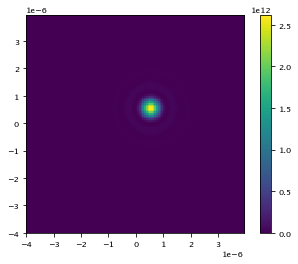

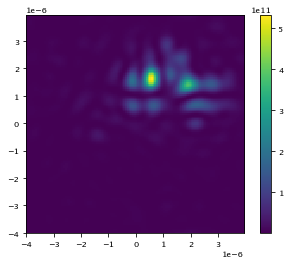

In [7]:
imshow_field(tt_img)
plt.colorbar()
plt.show()
imshow_field(tt_img_ab)
plt.colorbar()
plt.show()

Given a phase screen, I can now compute how much tip and tilt exists in it.

Hypothesis: if I take out the least-squares tip and tilt, the CM will revert to (0, 0) with some spread due to higher orders. (To be tested later, it doesn't really matter for the moment.)

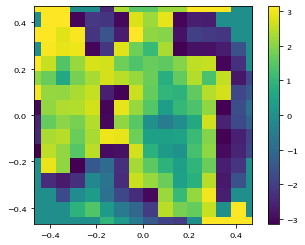

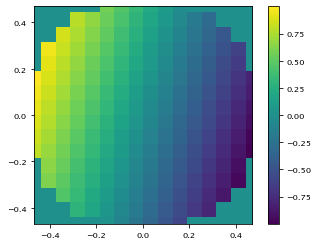

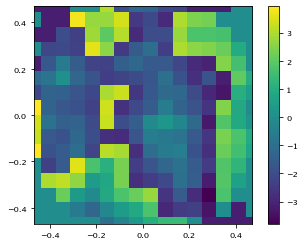

In [31]:
# run atmosphere tt in a loop so that it can be compared to the vibe amplitudes and powers
# first, let's figure out dimensions: the output plane is in pixels that I can translate to lambda-over-Ds by scaling
# by focal_samples. lambda-over-D is rad: 1 lambda over D \approx 500e-9/10 = 5e-8 = 10.313 mas, so one px is 1.29 mas
# That seems a bit high, but okay.

conversion = (wavelength / D) * 206265000 / focal_samples

tt_cms = np.zeros((f_sampling * T, 2))
for n in range(f_sampling * T):
    layer.evolve_until(times[n])
    wf = layer(Wavefront(aperture, wavelength))
    tt_phase = to_multiply.dot(wf.phase)
    tt_wf = Wavefront(aperture * np.exp(1j * tt_phase), wavelength)
    if n == 100:
        imshow_field(wf.phase)
        plt.colorbar()
        plt.show()
        imshow_field(tt_wf.phase)
        plt.colorbar()
        plt.show()
        imshow_field(tt_wf.phase - wf.phase)
        plt.colorbar()
        plt.show()
    total_intensity = prop(tt_wf).intensity

    # problem with this: it's using a basis in intensity space, 
    # so it's only producing intensity-scaled one-diffraction-width tip-tilt. I need to 
    # - use least-squares on the phase to get the tip-tilt
    # - propagate that back to an intensity
    # this is fine to do because it's all in simulation
    
tt_cms *= conversion # pixels to mas

Text(0.5, 1.0, 'Atmospheric tip-tilts')

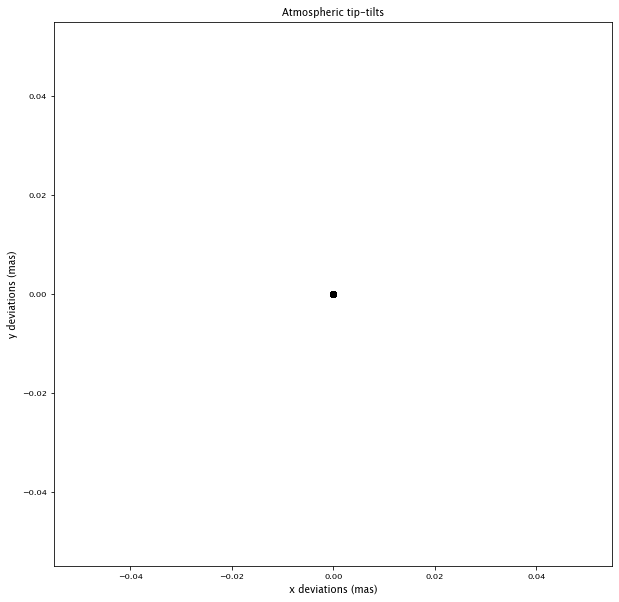

In [24]:
plt.figure(figsize=(10,10))
plt.plot(tt_cms[:,0], tt_cms[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Atmospheric tip-tilts")

(1e-07, 36.35518350613505)

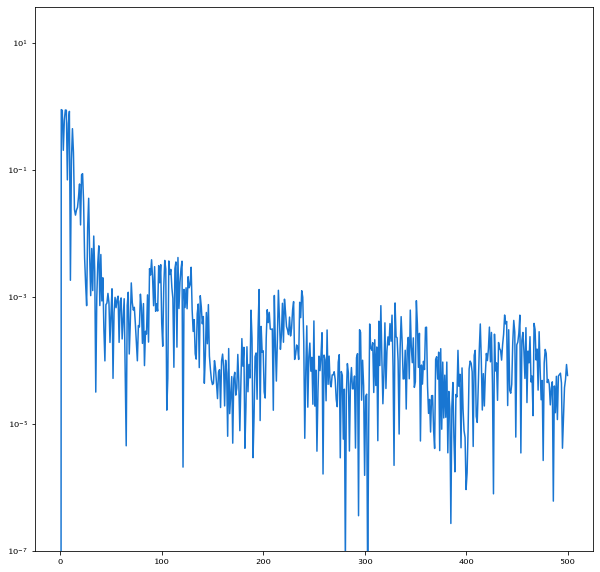

In [18]:
plt.figure(figsize=(10,10))
plt.semilogy(*signal.periodogram(tt_cms[:,1], f_sampling))
plt.ylim(1e-7)